<a href="https://colab.research.google.com/github/EliasBestard/Novel-Covid-19-dataset-/blob/main/covid_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies


In [ ]:
!pip install leven
!pip install --upgrade mlxtend
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

import pandas as pd
import numpy as np
import seaborn as sns
import copy

import nltk
import re
import string
from sklearn.cluster import dbscan

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import datetime

from leven import levenshtein  

#change to the path where the dataset is
# df =  pd.read_csv("path_of_dataset")
df =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/latestdata.csv")
df.head()

     |████████████████████████████████| 163kB 5.8MB/s 
  Created wheel for leven: filename=leven-1.0.4-cp36-cp36m-linux_x86_64.whl size=54677 sha256=e3374f21f855c80330c88abf505496470f47b0ec0fe7bc6b19599d0be84b9dbc
  Stored in directory: /root/.cache/pip/wheels/54/64/a5/439db671d666a50f3b3cebd2dcab3fbbab02785adf58e47552
Successfully built leven
     |████████████████████████████████| 1.4MB 5.3MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


# Exploratory Analysis


> ## Visualice missing values and features









In [ ]:
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   age                       object 
 2   sex                       object 
 3   city                      object 
 4   province                  object 
 5   country                   object 
 6   latitude                  float64
 7   longitude                 float64
 8   geo_resolution            object 
 9   date_onset_symptoms       object 
 10  date_admission_hospital   object 
 11  date_confirmation         object 
 12  symptoms                  object 
 13  lives_in_Wuhan            object 
 14  travel_history_dates      object 
 15  travel_history_location   object 
 16  reported_market_exposure  object 
 17  additional_information    object 
 18  chronic_disease_binary    bool   
 19  chronic_disease           object 
 20  source                  

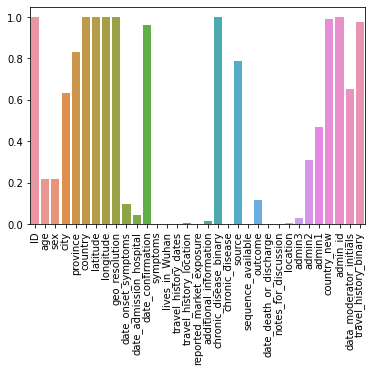

In [ ]:
ax = sns.barplot(x=[column for column in df.columns], y=[len( df.loc[df[item].isnull()==False])/df.shape[0] for item in df.columns])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]

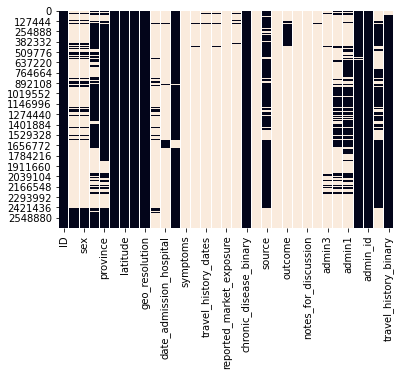

In [ ]:
sns.heatmap(df.isnull(), cbar=False)



> ## Drop some columns 



In [ ]:
#DROPPING DUPLICATES
df=df.drop('ID',axis=1).drop_duplicates()

In [ ]:
to_remove=[ 'city', 'latitude','province','date_admission_hospital',
       'longitude', 'geo_resolution',
       'lives_in_Wuhan', 'travel_history_location',"travel_history_dates",
       'reported_market_exposure', 'additional_information', 'chronic_disease', 'source',
       'sequence_available', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials']

df = df.drop(to_remove,axis=1)
df.head()

,age,sex,country,date_onset_symptoms,date_confirmation,symptoms,chronic_disease_binary,outcome,travel_history_binary
0,NaN,male,China,NaN,14.02.2020,NaN,False,"critical condition, intubated as of 14.02.2020",NaN
1,78,male,Italy,NaN,21.02.2020,NaN,False,death,NaN
2,61,female,Singapore,NaN,14.02.2020,NaN,False,discharge,NaN
3,NaN,NaN,China,NaN,26.01.2020,NaN,False,NaN,NaN
4,NaN,NaN,China,NaN,14.02.2020,NaN,False,NaN,NaN


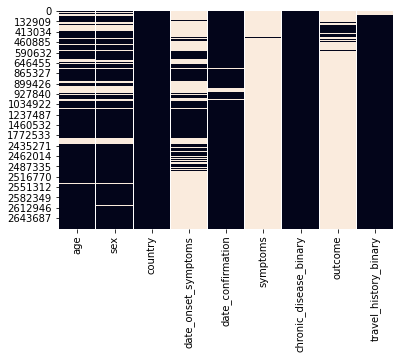

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

# Preprocessing


>  ## Standardizing 'Outcome'

In [ ]:
len(df.outcome.unique())

35

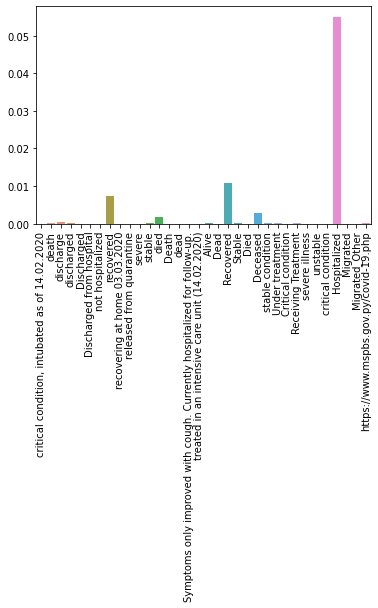

In [ ]:
ax = sns.barplot(x=[column for column in df.outcome.unique()], y=[len( df.loc[df.outcome==item])/df.shape[0] for item in df.outcome.unique()])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]

In [ ]:
df.loc[
       (df.outcome == 'death') | (df.outcome == 'died') |
       (df.outcome == 'Death') | (df.outcome == 'dead') |
       (df.outcome == 'Dead') | (df.outcome == 'Died') |
       (df.outcome == 'Deceased') ,'outcome'
       ]=0  #'dead'

df.loc[
       (df.outcome == 'critical condition, intubated as of 14.02.2020') | (df.outcome == 'severe') |
       (df.outcome == 'treated in an intensive care unit (14.02.2020)') | (df.outcome == 'Critical condition') |
       (df.outcome == 'severe illness') | (df.outcome == 'unstable') |
       (df.outcome == 'critical condition') ,'outcome'
       ]=1  #'critical'

df.loc[
       (df.outcome == 'discharge') | (df.outcome == 'discharged') |
       (df.outcome == 'Discharged') | (df.outcome == 'Discharged from hospital') |
       (df.outcome == 'released from quarantine') | (df.outcome == 'recovering at home 03.03.2020') |
       (df.outcome == 'not hospitalized') ,'outcome'
       ]=2  #'discharged'

df.loc[
       (df.outcome == 'recovered') | (df.outcome == 'Recovered') ,'outcome'
       ]=3  #'recovered'

df.loc[
       (df.outcome == 'stable') | (df.outcome == 'Symptoms only improved with cough. Currently hospitalized for follow-up.') |
       (df.outcome == 'Stable') | (df.outcome == 'stable condition') | (df.outcome == 'Alive'),'outcome'
       ]=4  #'stable'

df.loc[
       (df.outcome == 'Hospitalized') | (df.outcome == 'Under treatment') |
       (df.outcome == 'Receiving Treatment')|(df.outcome == 'Migrated') | (df.outcome == 'Migrated_Other')
       ,'outcome'
       ]=5  #'hospitalized'

# To Blank
df.loc[
       (df.outcome == 'https://www.mspbs.gov.py/covid-19.php') | (df.outcome == 'nan'),'outcome'
       ]=np.nan

df.outcome=pd.to_numeric(df.outcome, downcast='integer', errors='ignore')

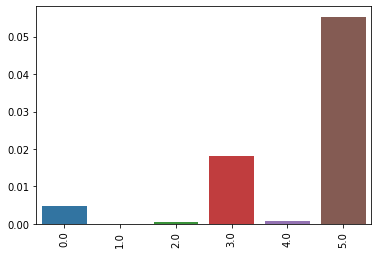

In [ ]:
ax = sns.barplot(x=[column for column in df.outcome.unique()], y=[len( df.loc[df.outcome==item])/df.shape[0] for item in df.outcome.unique()])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]

>  ## Standardizing 'Age'

In [ ]:
df.age=pd.to_numeric(df.age, errors='coerce',downcast='integer')
df.age = df.age.apply(lambda x: int(x) if pd.notna(x) else x)

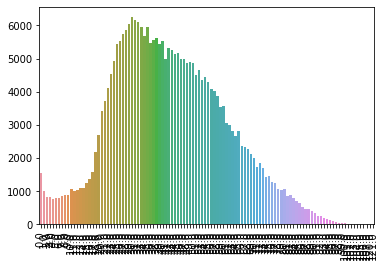

In [ ]:
ax = sns.barplot(x=[column for column in df.age.unique()], y=[len( df.loc[df.age==item]) for item in df.age.unique()])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]

>> ### Outlayers and Missing values

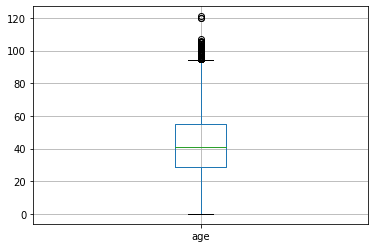

In [ ]:
df.boxplot(column=['age'])

In [ ]:
df.age.describe().astype(int)

count    274762
mean         42
std          18
min           0
25%          29
50%          41
75%          55
max         121
Name: age, dtype: int64

In [ ]:
mu, sigma = 41, 17 # mean and standard deviation
df.loc[df.age.isnull()==True, 'age'] =  abs(np.random.normal(mu, sigma,len(df.loc[df.age.isnull()==True])).astype(int))
df.age.describe().astype(int)

count    503791
mean         41
std          17
min           0
25%          29
50%          41
75%          53
max         121
Name: age, dtype: int64

In [ ]:
df=df.drop(df.loc[df.age>90].index)

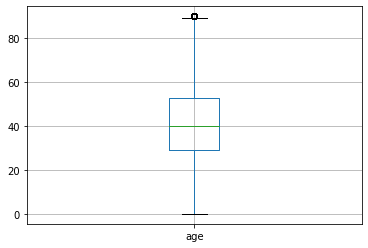

In [ ]:
df.boxplot(column=['age'])

> ## Standardizing 'Symptoms' using DBScan to group them

In [ ]:
len(df.symptoms.unique())

449

In [ ]:
#cleaning each sympthom and split it into different ones
def clean_keys(keys):
  
  list_keys={}
  cleanned_key=[]

  for item in keys:
    result = re.sub(r'\d+', '', item)

    # cleanned_key=[]

    for x in result.strip().split(','):
      temp= x.lower()
      temp = x.replace('°', '')
      temp = temp.replace('℃', '')
      temp = temp.replace('&', ',')
      temp = temp.replace('~', '')
      temp= temp.translate(str.maketrans('', '', string.punctuation))
      temp = temp.strip()
      
      if not temp in cleanned_key:
        cleanned_key.append(temp)
    
    # list_keys[item]=cleanned_key
  
  return cleanned_key
  # return list_keys


# data = clean_keys(df.symptoms.unique().astype(str))

In [ ]:
df.symptoms= df.symptoms.str.lower()
data = df.symptoms.unique().astype(str)

def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein(data[i], data[j])

X = np.arange(len(data)).reshape(-1, 1)
dbscan_out=dbscan(X, metric=lev_metric, eps=4, min_samples=2)
# s

In [ ]:
clusters={}
for item,cluster in zip(dbscan_out[0],dbscan_out[1]):
  if cluster in clusters.keys():
    clusters[cluster].append(data[item])
  else:
    clusters[cluster]=[data[item]]
count=0
for i in clusters.keys():
  count+=len(clusters[i])
  
print("====== NUmber of clusters ======")
print(count)

df['symptoms_dbscan']=np.nan
for key in data:
  for i in clusters.keys():
    if key in clusters[i]:
      df.loc[df.symptoms==key,'symptoms_dbscan']=i
      break

====== NUmber of clusters ======
99


In [ ]:
df = df.drop("symptoms",axis=1)

> ## Standardizing 'Sex'

In [ ]:
le2 = preprocessing.LabelEncoder()
le2.fit([x for x in df.sex.unique() if pd.notna(x)])
# list(le2.classes_)
df.sex = df.sex.apply( lambda x: le2.transform([str(x)])[0] if pd.notna(x) else x)

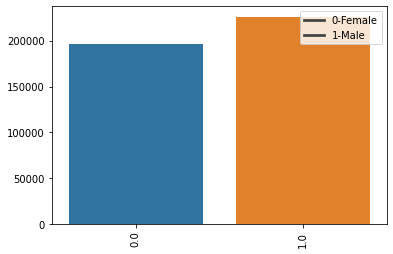

In [ ]:
ax = sns.barplot(x=[column for column in df.sex.unique()], y=[len( df.loc[df.sex==item]) for item in df.sex.unique()])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]

ax.legend(labels=['0-Female', '1-Male'])

> ## Standardizing 'Countries'

In [ ]:
#Encoding Countries
le = preprocessing.LabelEncoder()
le.fit([x for x in df.country.unique() if pd.notna(x)])
# list(le.classes_)
df.country = df.country.apply( lambda x: le.transform([str(x)])[0] if pd.notna(x) else x)

# list(le.inverse_transform([2, 2, 1]))

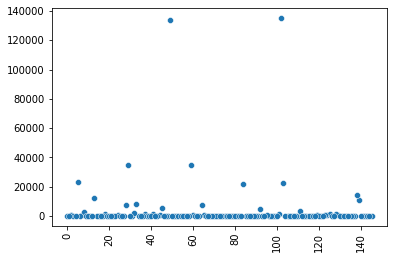

In [ ]:
ax = sns.scatterplot(x=[column for column in df.country.unique()], y=[len( df.loc[df.country==item]) for item in df.country.unique()])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]


> ## Standardizing 'travel_history_binary'

In [ ]:
#Encoding Travel_history
df.travel_history_binary = df.travel_history_binary.astype(bool)

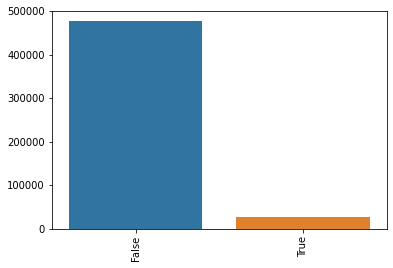

In [ ]:
ax = sns.barplot(x=[column for column in df.travel_history_binary.unique()], y=[len( df.loc[df.travel_history_binary==item]) for item in df.travel_history_binary.unique()])
s=[item.set_rotation(90) for item in ax.get_xticklabels()]


> ## Standardizing 'date_time' values

In [ ]:
#one wrong date format
df.loc[df.date_onset_symptoms=='01.31.2020', 'date_onset_symptoms']='31.01.2020'

In [ ]:
#setting each day to datetime
min_onset=datetime.datetime.strptime('31.12.2021', '%d.%m.%Y')
for item in df.date_onset_symptoms.unique():
  if pd.notna(item):
    temp_date = datetime.datetime.strptime(str(item)[:10], '%d.%m.%Y')
    min_onset = temp_date if temp_date < min_onset else min_onset

#standadize to number of days since the minimal
df.date_onset_symptoms = df.date_onset_symptoms.apply(lambda x: abs(datetime.datetime.strptime(str(x)[:10], '%d.%m.%Y')-min_onset).days if pd.notna(x) else np.nan)

In [ ]:
df.date_confirmation = df.date_confirmation.apply(lambda x: abs(datetime.datetime.strptime(str(x)[:10], '%d.%m.%Y')-min_onset).days if pd.notna(x) else np.nan)

In [ ]:
a=df.loc[(df.date_confirmation.isnull()==False) & (df.date_onset_symptoms.isnull()==False) ]

In [ ]:
(a.date_confirmation - a.date_onset_symptoms).describe()

count    213783.000000
mean          6.566158
std           7.351204
min         -49.000000
25%           1.000000
50%           5.000000
75%           9.000000
max         138.000000
dtype: float64

> > ### MIssing values. Set the missing values to the mean difference between the confirmation day and the onset symptoms day

In [ ]:
#Filling up the missing values on date_confiramtion by adding the mean diff to the onset_symptoms day

df.loc[(df.date_confirmation.isnull()==True) & (df.date_onset_symptoms.isnull()==False),'date_confirmation']=df.loc[(df.date_onset_symptoms.isnull()==False) & (df.date_confirmation.isnull()==True),'date_onset_symptoms']+6

In [ ]:
df.loc[df.date_confirmation.isnull()==False,'date_confirmation'].describe().astype(int)

count    493097
mean        136
std          26
min           6
25%         115
50%         137
75%         160
max         358
Name: date_confirmation, dtype: int64

In [ ]:
#filling up the missing values with a random distribution

mu, sigma = 133, 25 # mean and standard deviation
df.loc[df.date_confirmation.isnull()==True, 'date_confirmation'] =  np.random.normal(mu, sigma,len(df.loc[df.date_confirmation.isnull()==True])).astype(int)
df.loc[df.date_confirmation.isnull()==False,'date_confirmation'].describe().astype(int)

count    502228
mean        136
std          26
min           6
25%         115
50%         137
75%         160
max         358
Name: date_confirmation, dtype: int64

In [ ]:
#Filling up the missing values on date_onset_symptoms by adding the mean diff to the onset_symptoms day
df.loc[(df.date_onset_symptoms.isnull()==True) & (df.date_confirmation.isnull()==False),'date_onset_symptoms']=df.loc[(df.date_onset_symptoms.isnull()==True) & (df.date_confirmation.isnull()==False),'date_confirmation']-6

> ## Adding a new column= diff between onset date of symptoms and date of confirmation

In [ ]:
df['diff_date_onset_confirmation']=df.date_confirmation-df.date_onset_symptoms

# Predicting Outcome

## Getting the columns with and without outcome

In [ ]:
without_outcome = copy.deepcopy(df.loc[df.outcome.isnull()==True])
without_outcome = without_outcome.drop('outcome',axis=1)
without_outcome = without_outcome.drop('sex',axis=1)
without_outcome = without_outcome.drop('symptoms_dbscan',axis=1)
# without_outcome = without_outcome.drop('diff_date_onset_confirmation',axis=1)

print(without_outcome.shape)

X = copy.deepcopy(df.drop(df.loc[df.outcome.isnull()==True].index))
X = X.drop(X.loc[X.country.isnull()==True].index)
# X=X.drop_duplicates()
# X = X.drop(X.loc[X.symptoms_dbscan.isnull()==True].index)

y = copy.deepcopy(X.outcome)
X = X.drop('outcome',axis=1)
X = X.drop('sex',axis=1)
X = X.drop('symptoms_dbscan',axis=1)
# X = X.drop('diff_date_onset_confirmation',axis=1)

(462182, 7)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40044 entries, 0 to 673607
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           40044 non-null  float64
 1   country                       40044 non-null  float64
 2   date_onset_symptoms           40044 non-null  float64
 3   date_confirmation             40044 non-null  float64
 4   chronic_disease_binary        40044 non-null  bool   
 5   travel_history_binary         40044 non-null  bool   
 6   diff_date_onset_confirmation  40044 non-null  float64
dtypes: bool(2), float64(5)
memory usage: 1.9 MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

> ## KNN

In [ ]:
# classifier = KNeighborsClassifier(n_neighbors=108)
classifier = KNeighborsClassifier(n_neighbors=25)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  130     0     9   237     7   619]
 [    0     0     2     0     2     1]
 [    3     0    97     0    20     0]
 [   59     0     5  1487     2  2183]
 [    6     0     1     7    97    21]
 [    3     0     0    44     0 10976]]
              precision    recall  f1-score   support

         0.0       0.65      0.13      0.22      1002
         1.0       0.00      0.00      0.00         5
         2.0       0.85      0.81      0.83       120
         3.0       0.84      0.40      0.54      3736
         4.0       0.76      0.73      0.75       132
         5.0       0.80      1.00      0.88     11023

    accuracy                           0.80     16018
   macro avg       0.65      0.51      0.54     16018
weighted avg       0.80      0.80      0.76     16018



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 200):
  print('================== ' + str(i) +' ================== ')
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  pred_i = knn.predict(X_test)
  error.append(np.mean(pred_i != y_test))
  print(np.mean(pred_i != y_test))

================== 1 ================== 
0.2936071919091023
================== 2 ================== 
0.382881758022225
================== 3 ================== 
0.2604569858908728
================== 4 ================== 
0.26957173180172306
================== 5 ================== 
0.23941815457610188
================== 6 ================== 
0.2386689973779498
================== 7 ================== 
0.22081408415532525
================== 8 ================== 
0.21987763765763516
================== 9 ================== 
0.21113747034586092
================== 10 ================== 
0.21226120614308902
================== 11 ================== 
0.20776626295417655
================== 12 ================== 
0.20751654388812585
================== 13 ================== 
0.20589336995879634
================== 14 ================== 
0.20732925458858784
================== 15 ================== 
0.20451991509551753
================== 16 ================== 
0.20520664252715695
================== 17 

In [ ]:
error.index(min(error))

22

Text(0, 0.5, 'Mean Error')

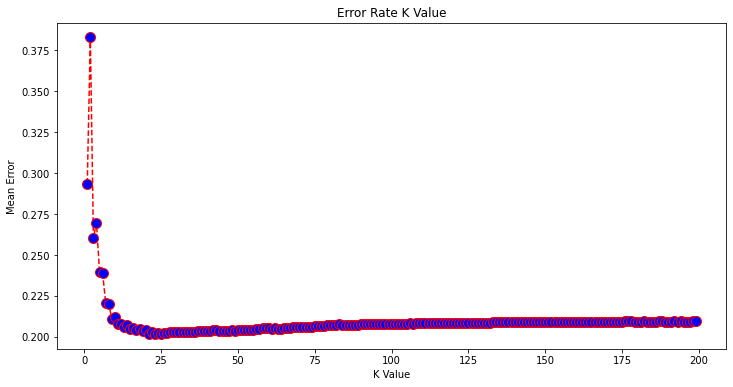

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 200), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

> ## Decision Tree

In [ ]:
classifier2 = DecisionTreeClassifier(criterion='entropy')
classifier2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = classifier2.predict(X_test)
# y_pred = classifier2.predict(X)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# print(confusion_matrix(y, y_pred))
# print(classification_report(y, y_pred))

[[  213     0     9   252     5   523]
 [    0     2     0     0     3     0]
 [    2     0   112     2     4     0]
 [  291     0     3  1489     2  1951]
 [    3     3     3     0   121     2]
 [  157     1     0   606     0 10259]]
              precision    recall  f1-score   support

         0.0       0.32      0.21      0.26      1002
         1.0       0.33      0.40      0.36         5
         2.0       0.88      0.93      0.91       120
         3.0       0.63      0.40      0.49      3736
         4.0       0.90      0.92      0.91       132
         5.0       0.81      0.93      0.86     11023

    accuracy                           0.76     16018
   macro avg       0.65      0.63      0.63     16018
weighted avg       0.74      0.76      0.74     16018



> ## MLP

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [ ]:
clf.predict_proba(X_test)

array([[1.03443876e-02, 1.19806569e-06, 4.18955454e-04, 1.70589717e-01,
        1.08343506e-03, 8.17562307e-01],
       [1.03596844e-02, 3.55579057e-08, 4.15016964e-04, 1.68447697e-01,
        1.96954440e-03, 8.18808022e-01],
       [1.79542234e-02, 7.84168964e-05, 1.31593602e-03, 1.21057415e-01,
        1.51726057e-03, 8.58076748e-01],
       ...,
       [1.42290977e-02, 1.21259587e-06, 5.32406408e-04, 2.16563624e-01,
        1.66769555e-03, 7.67005963e-01],
       [5.81880219e-03, 7.79652904e-06, 2.37608724e-04, 8.61860851e-02,
        3.11463932e-04, 9.07438244e-01],
       [1.65163917e-02, 1.54483615e-05, 8.50991017e-04, 2.21603976e-01,
        1.26768459e-03, 7.59745509e-01]])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.791734298913722

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   47     0    36   280     3   636]
 [    0     0     1     0     3     1]
 [    0     0   107     1    12     0]
 [    2     0    20  1497    15  2202]
 [    1     0    34    13    44    40]
 [    1     0     1    34     0 10987]]
              precision    recall  f1-score   support

         0.0       0.92      0.05      0.09      1002
         1.0       0.00      0.00      0.00         5
         2.0       0.54      0.89      0.67       120
         3.0       0.82      0.40      0.54      3736
         4.0       0.57      0.33      0.42       132
         5.0       0.79      1.00      0.88     11023

    accuracy                           0.79     16018
   macro avg       0.61      0.44      0.43     16018
weighted avg       0.80      0.79      0.75     16018



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross Validation

In [ ]:
knn_scores = cross_val_score(classifier, X, y, cv=10,verbose=True)
mlp_scores = cross_val_score(clf, X, y, cv=10,verbose=True)
dt_scores = cross_val_score(classifier2, X, y, cv=10,verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [ ]:
sum(knn_scores)/10

0.6067567077117638

In [ ]:
sum(mlp_scores)/10

0.7896380149189137

In [ ]:
sum(dt_scores)/10

0.4343685029078287

> ## *italicized text*

In [ ]:
without_outcome = without_outcome.drop(without_outcome.loc[without_outcome.age.isnull()==True].index)
without_outcome = without_outcome.drop(without_outcome.loc[without_outcome.country.isnull()==True].index)
without_outcome = without_outcome.drop(without_outcome.loc[without_outcome.date_onset_symptoms.isnull()==True].index)
without_outcome = without_outcome.drop(without_outcome.loc[without_outcome.chronic_disease_binary.isnull()==True].index)
without_outcome = without_outcome.drop(without_outcome.loc[without_outcome.travel_history_binary.isnull()==True].index)

# y_pred = classifier.predict(without_outcome)
y_pred = clf.predict(without_outcome)
df.loc[without_outcome.index,'outcome']=y_pred

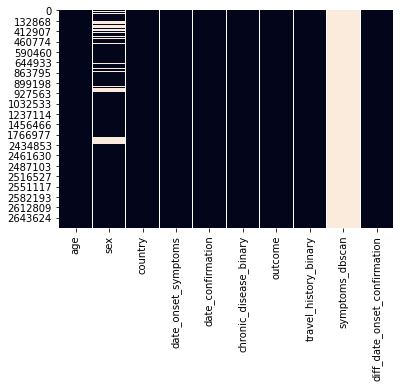

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

# Association Rule Mining



>  ## Cleanning for Association Rules

In [ ]:
a=copy.deepcopy(df)
# a = a.drop("date_onset_symptoms",axis=1)
# a = a.drop("date_confirmation",axis=1)
a = a.drop("symptoms_dbscan",axis=1)
# a = a.drop("sex",axis=1)
# a = a.drop("diff_date_onset_confirmation",axis=1)

# a=a.drop_duplicates()

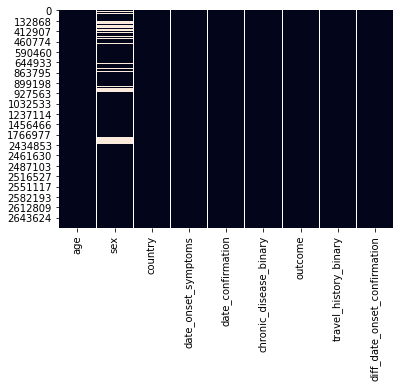

In [ ]:
sns.heatmap(a.isnull(), cbar=False)

> ## One Hot Encoding

In [ ]:
my_copy=copy.deepcopy(a)

my_copy['age']=my_copy['age'].apply(lambda x: str(x) + "_age")
my_copy['sex']=my_copy['sex'].apply(lambda x: str(x) + "_sex")
my_copy['country']=my_copy['country'].apply(lambda x: str(x) + "_country")
# my_copy['province']=my_copy['province'].apply(lambda x: str(x) + "_province")
my_copy['date_confirmation']=my_copy['date_confirmation'].apply(lambda x: str(x) + "_date_confi")
my_copy['chronic_disease_binary']=my_copy['chronic_disease_binary'].apply(lambda x: str(x) + "_chronic_disease")
my_copy['outcome']=my_copy['outcome'].apply(lambda x: str(x) + "_outcome")
my_copy['travel_history_binary']=my_copy['travel_history_binary'].apply(lambda x: str(x) + "_travel")
# my_copy['symptoms_dbscan']=my_copy['symptoms_dbscan'].apply(lambda x: str(x) + "_symptoms_dbscan")
my_copy['date_onset_symptoms']=my_copy['date_onset_symptoms'].apply(lambda x: str(x) + "_date_onset")
my_copy['diff_date_onset_confirmation']=my_copy['diff_date_onset_confirmation'].apply(lambda x: str(x) + "diff_date")

my_copy=my_copy.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(my_copy).transform(my_copy)
trans_df = pd.DataFrame(te_ary, columns=te.columns_)

>  ## FP-growth

In [ ]:
fp_out=fpgrowth(trans_df, min_support=0.3, use_colnames=True)
fp_out.loc[(fp_out.itemsets.astype(str).str.contains("nan_", regex=False)==False )]

,support,itemsets
0,0.999632,(False_chronic_disease)
1,0.600466,(6.0diff_date)
2,0.450140,(1.0_sex)
3,0.390456,(0.0_sex)
4,0.369904,(3.0_outcome)
5,0.440684,(5.0_outcome)
6,0.948231,(False_travel)
7,0.600203,"(False_chronic_disease, 6.0diff_date)"
8,0.565942,"(False_travel, 6.0diff_date)"
9,0.565872,"(False_chronic_disease, False_travel, 6.0diff_..."


In [ ]:
p=association_rules(fp_out, metric="confidence", min_threshold=0.4)
p.loc[(p.antecedents.astype(str).str.contains("nan_", regex=False)==False ) & (p.consequents.astype(str).str.contains("nan_", regex=False)==False ) & (p.lift>=1 ),['antecedents','consequents','support','confidence','lift']]

,antecedents,consequents,support,confidence,lift
6,"(False_travel, 6.0diff_date)",(False_chronic_disease),0.565872,0.999877,1.000245
7,(False_chronic_disease),"(False_travel, 6.0diff_date)",0.565872,0.566081,1.000245
12,(1.0_sex),(False_travel),0.431655,0.958934,1.011287
13,(False_travel),(1.0_sex),0.431655,0.455221,1.011287
14,"(False_chronic_disease, 1.0_sex)",(False_travel),0.431601,0.959332,1.011707
15,"(False_chronic_disease, False_travel)",(1.0_sex),0.431601,0.455203,1.011246
16,"(1.0_sex, False_travel)",(False_chronic_disease),0.431601,0.999875,1.000244
17,(False_chronic_disease),"(1.0_sex, False_travel)",0.431601,0.431760,1.000244
18,(1.0_sex),"(False_chronic_disease, False_travel)",0.431601,0.958814,1.011246
19,(False_travel),"(False_chronic_disease, 1.0_sex)",0.431601,0.455164,1.011707


In [ ]:
p.loc[(p.antecedents.astype(str).str.contains("nan_", regex=False)==False ) & (p.consequents.astype(str).str.contains("nan_", regex=False)==False ) & (p.lift<=1 )]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(False_chronic_disease),(6.0diff_date),0.999632,0.600466,0.600203,0.600425,0.999931,-0.000042,0.999896
1,(6.0diff_date),(False_chronic_disease),0.600466,0.999632,0.600203,0.999562,0.999931,-0.000042,0.841563
2,(False_travel),(6.0diff_date),0.948231,0.600466,0.565942,0.596840,0.993961,-0.003438,0.991006
3,(6.0diff_date),(False_travel),0.600466,0.948231,0.565942,0.942504,0.993961,-0.003438,0.900405
4,"(False_chronic_disease, False_travel)",(6.0diff_date),0.948151,0.600466,0.565872,0.596817,0.993922,-0.003460,0.990948
5,"(False_chronic_disease, 6.0diff_date)",(False_travel),0.600203,0.948231,0.565872,0.942801,0.994274,-0.003259,0.905074
8,(False_travel),"(False_chronic_disease, 6.0diff_date)",0.948231,0.600203,0.565872,0.596767,0.994274,-0.003259,0.991477
9,(6.0diff_date),"(False_chronic_disease, False_travel)",0.600466,0.948151,0.565872,0.942388,0.993922,-0.003460,0.899974
10,(False_chronic_disease),(1.0_sex),0.999632,0.450140,0.449897,0.450063,0.999829,-0.000077,0.999860
11,(1.0_sex),(False_chronic_disease),0.450140,0.999632,0.449897,0.999460,0.999829,-0.000077,0.682590
